In this project we will explore dimansion reduction and clustering using PCA, t-SNA and K-Means.

## Import and Normalize Cloud Data

The data file should be imported one-line at a time and checked whether it contiains text or number. We don't need the former, but we need the numbers to carry out downstream analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import time
from scipy.ndimage import gaussian_filter

In [2]:
# Since this is a unix command, we use "!" at the beginning
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/taylor/cloud.data

--2022-04-21 03:50:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/taylor/cloud.data
Resolving archive.ics.uci.edu... 128.195.10.252
Connecting to archive.ics.uci.edu|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209266 (204K) [application/x-httpd-php]
Saving to: 'cloud.data.1'

cloud.data.1        100%[===================>] 204.36K   249KB/s    in 0.8s    

2022-04-21 03:50:02 (249 KB/s) - 'cloud.data.1' saved [209266/209266]



In [3]:
# Open the data file and read it line by line
cloud = []

with open("cloud.data") as fid:
    for aline in fid:
        aline = aline.strip().split()
        try:
            l = list(map(float, aline))
            if l:
                cloud.append(l)
        except: None

In [4]:
cloud = np.array(cloud)
cloud

array([[  3.    , 140.    ,  43.5   , ..., 163.    , 240.    , 213.3555],
       [  3.    , 135.    ,  41.9063, ..., 167.    , 239.    , 213.7188],
       [  2.    , 126.    ,  21.0586, ..., 174.    , 240.    , 227.5859],
       ...,
       [  7.9397,  48.7863,  20.7169, ..., -79.7594,  30.7739, -11.1662],
       [  6.6498,  61.2553,  23.0195, ..., -71.842 ,  29.9047,   0.711 ],
       [  4.9299,  31.5877,  14.6402, ..., -52.3305,  34.0016,   4.5046]])

In [5]:
cloud.shape

(2048, 10)

In [6]:
cloudz = np.zeros(cloud.shape)
for cols in range(cloud.shape[1]):
    mean = np.mean(cloud[:,cols])
    std = np.std(cloud[:,cols], ddof = 1) # biased STD here!
    cloudz[:,cols] = (cloud[:,cols] - mean)/std

In [7]:
print(np.mean(cloudz[:,0])) # zero
print(np.std(cloudz[:,0])) # 1

2.7755575615628914e-17
0.9997558295653994


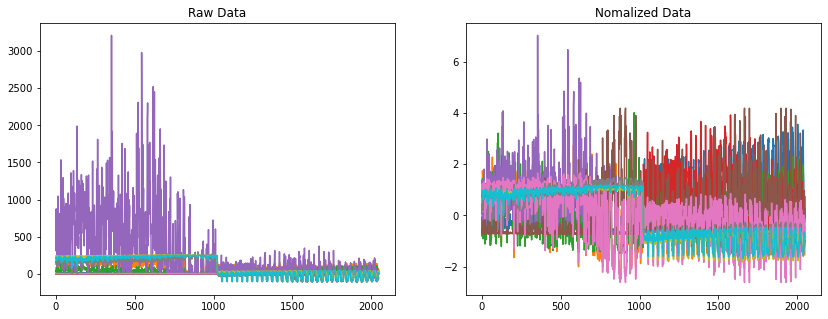

In [8]:
fig,ax = plt.subplots(1,2, figsize = (14,5))

ax[0].plot(cloud)
ax[0].set_title("Raw Data")

ax[1].plot(cloudz)
ax[1].set_title("Nomalized Data")

plt.show()

# Its a crapy plot

## Compute Covariance Matrix

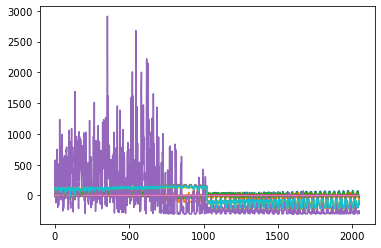

In [9]:
# Each column should be mean-centered before computing the covriance matrix
# First, raw data mean-centered but not divided by Standard Deviation
raw_data = (cloud - cloud.mean(axis=0))
plt.plot(raw_data);

In [10]:
# Covariance matrices for features
cov_features = raw_data.T @ raw_data / (raw_data.shape[1] - 1)
#cov_features.shape

cov_featuresZ = cloudz.T @ cloudz / (cloudz.shape[1] - 1)
#cov_featuresZ.shape

# Covariance Matrices for Observations
cov_obs = raw_data @ raw_data.T / (raw_data.shape[0] - 1)
#cov_features.shape

cov_obsZ = cloudz @ cloudz.T / (cloudz.shape[0] - 1)

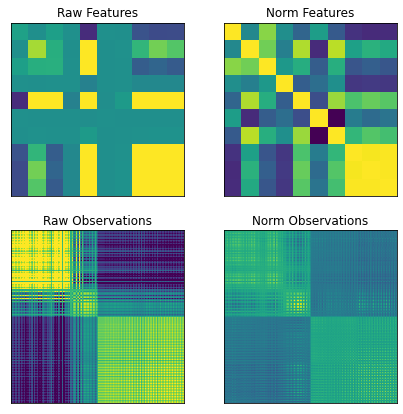

In [11]:
fig,ax = plt.subplots(2,2, figsize = (7,7))
                      
ax[0,0].imshow(cov_features, vmin = -8e5, vmax = 8e5)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title("Raw Features")

ax[0,1].imshow(cov_featuresZ)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title("Norm Features")

ax[1,0].imshow(cov_obs, vmin = -8e1, vmax = 8e1)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_title("Raw Observations")

ax[1,1].imshow(cov_obsZ, vmin = -0.01, vmax = 0.01)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_title("Norm Observations")

plt.show()

## Number of Components with PCA

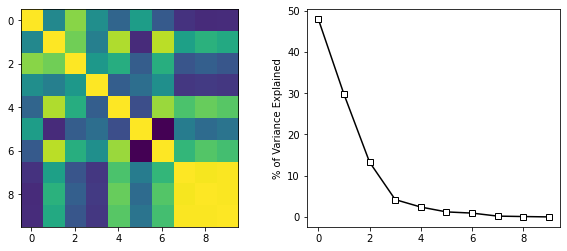

In [12]:
pca = PCA().fit(cloudz)

fig,ax = plt.subplots(1,2, figsize = (10,4))
                      
ax[0].imshow(pca.get_covariance())

ax[1].plot(100*pca.explained_variance_ratio_,"ks-",
          markerfacecolor = "w")
ax[1].set_ylabel("% of Variance Explained")
plt.show()

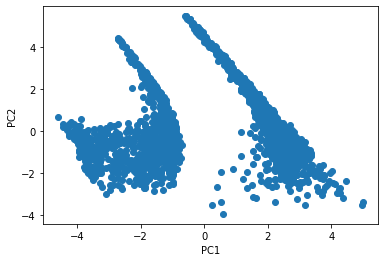

In [13]:
# Project the data down to 2 PCs
cloud2D = pca.transform(cloudz)

plt.plot(cloud2D[:,0], cloud2D[:,1], "o")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

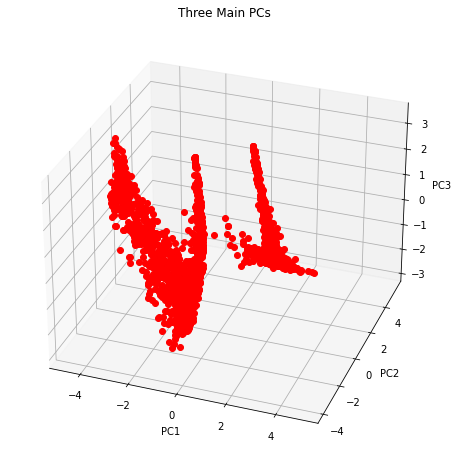

In [14]:
# Plot it in 3D to count for the three main components
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(cloud2D[:,0], cloud2D[:,1], cloud2D[:,2], "ro")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Three Main PCs")
ax.view_init(30, -70)

## Clustering with t-SNE and K-Means

Preplexity of analysis: It has to do with how complex is unfolding or unwraping in high dimensions. This is an important parameter of t-SNE. t-SNE is stochastic, not deterministic, so everytime it is run the results will not be exactly the same

In [15]:
t = TSNE().fit_transform(cloudz)

# Run K-Means on t-SNE
clusters = KMeans(n_clusters = 2).fit(t)

In [16]:
t.shape

(2048, 2)

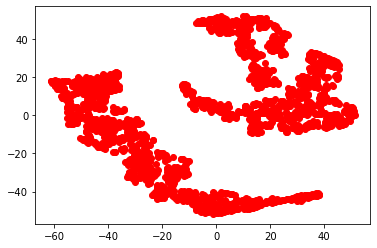

In [17]:
plt.plot(t[:,0], t[:,1], "ro")
plt.show()

In [18]:
clusters

KMeans(n_clusters=2)

In [19]:
len(clusters.labels_)
clusters.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

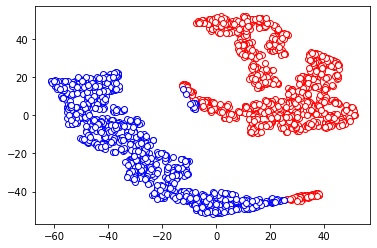

In [20]:
plt.plot(t[clusters.labels_==0,0], t[clusters.labels_==0,1], "ro",
        markerfacecolor = "w")
plt.plot(t[clusters.labels_==1,0], t[clusters.labels_==1,1], "bo",
        markerfacecolor = "w")
plt.show()

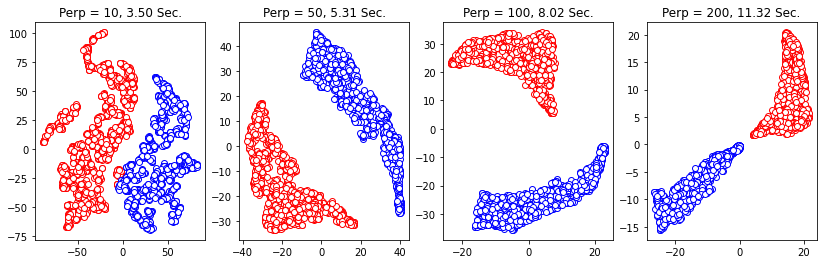

In [21]:
# Change preplexity
fig,ax = plt.subplots(1,4, figsize= (14,4))

perps = [10, 50, 100, 200]
for i in range(4):
    # start the timer
    starttime = time.time()
    
    # t-SNE and k-Means
    t = TSNE(perplexity = perps[i]).fit_transform(cloudz)
    clusters = KMeans(n_clusters = 2).fit(t)

    endtime = time.time() - starttime
    
    ax[i].plot(t[clusters.labels_==0,0], t[clusters.labels_==0,1], "ro",
        markerfacecolor = "w")
    ax[i].plot(t[clusters.labels_==1,0], t[clusters.labels_==1,1], "bo",
        markerfacecolor = "w")
    ax[i].set_title(f"Perp = {perps[i]}, {endtime:.2f} Sec.")

## Bonus Video: 2D Likelihood Density Plot

The output of t-SNE is alist of two columns

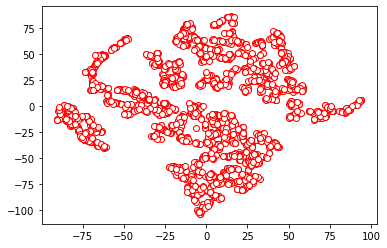

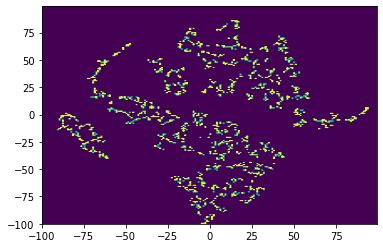

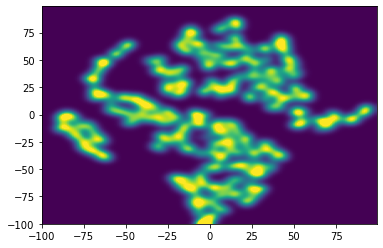

In [22]:
t = TSNE(perplexity = 10).fit_transform(cloudz)

# Set up the image
trange = np.arange(-100, 100)
timage = np.zeros((len(trange), len(trange)))

# Map sparse coordinates onto the desne matrix
for i in range(len(t)):
    xi = np.argmin((t[i,0] - trange)**2)
    yi = np.argmin((t[i,1] - trange)**2)
    timage[yi,xi] += 1

# smooth the image
timage_smooth = gaussian_filter(timage, sigma=(3,3))

plt.plot(t[:,0], t[:,1], "ro", markerfacecolor = "w")
plt.show()
plt.imshow(timage, vmin=0, vmax=1, origin = "lower",
          extent = [trange[0], trange[-1], trange[0], trange[-1]],
          aspect = "auto")
plt.show()

plt.imshow(timage_smooth, vmin=0, vmax=0.25, origin = "lower",
          extent = [trange[0], trange[-1], trange[0], trange[-1]],
          aspect = "auto")
plt.show()

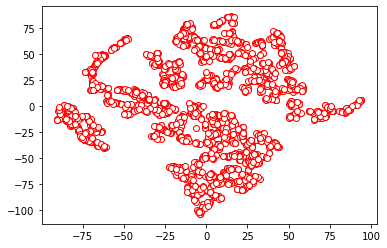

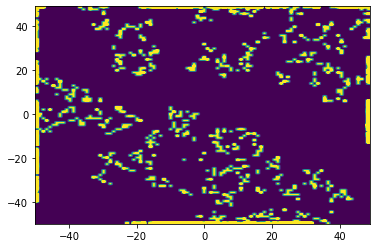

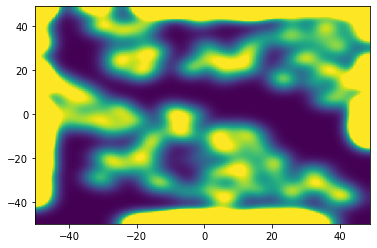

In [23]:
# Change the Boundaries
trange = np.arange(-50, 50)
timage = np.zeros((len(trange), len(trange)))

# Map sparse coordinates onto the desne matrix
for i in range(len(t)):
    xi = np.argmin((t[i,0] - trange)**2)
    yi = np.argmin((t[i,1] - trange)**2)
    timage[yi,xi] += 1

# smooth the image
timage_smooth = gaussian_filter(timage, sigma=(3,3))

plt.plot(t[:,0], t[:,1], "ro", markerfacecolor = "w")
plt.show()
plt.imshow(timage, vmin=0, vmax=1, origin = "lower",
          extent = [trange[0], trange[-1], trange[0], trange[-1]],
          aspect = "auto")
plt.show()

plt.imshow(timage_smooth, vmin=0, vmax=0.25, origin = "lower",
          extent = [trange[0], trange[-1], trange[0], trange[-1]],
          aspect = "auto")
plt.show()